In [1]:
import numpy as np
import h5py
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
from scipy.interpolate import interp1d
from scipy.stats import skew
from scipy.signal import butter, filtfilt
from scipy.integrate import trapezoid
import pandas as pd
import time

# ==========================================
# [0] 실험 환경 설정
# ==========================================
MAT_FILE = "/content/drive/MyDrive/Colab Notebooks/PusleDB/p043774.mat"
SEGMENT_LIMIT = None
PAD_LEN = 200
SEC_PER_SEGMENT = 10.0
BATCH_SIZE = 32
EPOCHS = 100
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using Device: {DEVICE}")

# ==========================================
# [1] 전처리 및 특징 추출 함수
# ==========================================
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    """4th order Butterworth filter"""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def cubic_resample(ppg, target_len=PAD_LEN):
    """Cubic Spline Resampling"""
    x_old = np.linspace(0, 1, len(ppg))
    x_new = np.linspace(0, 1, target_len)
    try:
        f = interp1d(x_old, ppg, kind='cubic', bounds_error=False, fill_value='extrapolate')
        return f(x_new).astype(np.float32)
    except:
        return np.interp(x_new, x_old, ppg).astype(np.float32)

def check_sqi_sliding(ppg_segment, duration_sec, window_sec=5.0):
    """
    Strict SQI: 5초 윈도우 중 하나라도 Skewness < 0이면 False 반환 (폐기)
    """
    fs = len(ppg_segment) / duration_sec
    win_len = int(fs * window_sec)
    step = int(fs * 1.0) # 1초 간격으로 이동

    # 데이터가 윈도우보다 짧으면 전체 검사
    if len(ppg_segment) < win_len:
        return skew(ppg_segment) >= 0

    # Sliding Window
    for i in range(0, len(ppg_segment) - win_len + 1, step):
        window = ppg_segment[i : i + win_len]
        if skew(window) < 0:
            return False
    return True

def extract_multiscale_morph_features(ppg):
    """
    Multi-scale Morphological Feature Extraction (44 dimensions)
    """
    scales = [100, 150, 200, 250]
    all_features = []

    for scale in scales:
        # Resample
        x = cubic_resample(ppg, scale)

        # Basic Points
        peak_idx = np.argmax(x)
        end_idx = scale - 1

        # Amplitude Features
        vp = x[peak_idx]
        vt = x[end_idx]
        dv = vp - vt
        vm = np.mean(x)
        std_val = np.std(x)

        # Temporal Features
        tvp = peak_idx / scale

        # Derivative Features
        diff = np.diff(x)
        kmax = np.max(diff) if len(diff) > 0 else 0
        tkmax = np.argmax(diff) / scale if len(diff) > 0 else 0

        # Area & Statistics
        # scipy.integrate.trapezoid 사용으로 경고 제거
        amax = trapezoid(x[:peak_idx]) if peak_idx > 0 else 0

        centered = x - vm
        skew_approx = np.mean(centered**3) / (std_val**3) if std_val > 0 else 0
        kurt_approx = np.mean(centered**4) / (std_val**4) if std_val > 0 else 0

        scale_features = [vp, vt, dv, vm, kmax, tkmax, amax, std_val, tvp, skew_approx, kurt_approx]
        all_features.extend(scale_features)

    return np.array(all_features, dtype=np.float32)

# ==========================================
# [2] 데이터 로딩 및 데이터셋 클래스
# ==========================================
def load_data_complete(mat_path, limit=None):
    print("Loading Raw Data...")
    raw_segments, raw_priors, raw_targets = [], [], []
    strict_indices = [] # Strict 조건을 만족하는 인덱스 리스트

    with h5py.File(mat_path, 'r') as f:
        refs = f['Subj_Wins']['PPG_F'][0]
        sbps = f['Subj_Wins']['SegSBP'][0]
        dbps = f['Subj_Wins']['SegDBP'][0]

        total = min(len(refs), limit) if limit else len(refs)

        for i in range(total):
            # 1. Load & Filter (Butterworth)
            ppg_raw = f[refs[i]][()].squeeze().astype(np.float32)
            fs = len(ppg_raw) / SEC_PER_SEGMENT
            ppg_filt = butter_bandpass_filter(ppg_raw, 0.5, 8.0, fs)

            # 2. Extract Features
            p_min = np.min(ppg_filt)
            p_max = np.max(ppg_filt)
            ppg_norm_for_feat = (ppg_filt - p_min) / (p_max - p_min + 1e-8)
            prior = extract_multiscale_morph_features(ppg_norm_for_feat)

            sbp = float(f[sbps[i]][()][0][0])
            dbp = float(f[dbps[i]][()][0][0])

            # 3. SQI Check (Strict Index 저장)
            # Sliding Window 통과 여부 확인
            if check_sqi_sliding(ppg_filt, SEC_PER_SEGMENT):
                strict_indices.append(i)

            raw_segments.append(ppg_filt)
            raw_priors.append(prior)
            raw_targets.append([sbp, dbp])

            if i % 1000 == 0: print(f"  Processed {i}/{total}...")

    return raw_segments, raw_priors, raw_targets, strict_indices

class PPGDataset(Dataset):
    def __init__(self, segments, priors, targets, indices=None):
        # indices가 있으면 해당 데이터만 사용 (Filtering 효과)
        if indices is not None:
            self.x = [segments[i] for i in indices]
            self.p = [priors[i] for i in indices]
            self.y_raw = [targets[i] for i in indices]
        else:
            self.x, self.p, self.y_raw = segments, priors, targets

        # Min-Max Normalization Setup
        sbps = [t[0] for t in self.y_raw]
        dbps = [t[1] for t in self.y_raw]
        self.sbp_min, self.sbp_max = min(sbps), max(sbps)
        self.dbp_min, self.dbp_max = min(dbps), max(dbps)

        # Pre-normalize Targets
        self.y_norm = []
        for t in self.y_raw:
            s_norm = (t[0] - self.sbp_min) / (self.sbp_max - self.sbp_min)
            d_norm = (t[1] - self.dbp_min) / (self.dbp_max - self.dbp_min)
            self.y_norm.append([s_norm, d_norm])

    def __len__(self): return len(self.x)

    def __getitem__(self, idx):
        # Cubic Resample은 __getitem__에서 수행 (메모리 절약)
        x_in = cubic_resample(self.x[idx], PAD_LEN)
        x_min = np.min(x_in)
        x_max = np.max(x_in)
        x_norm = (x_in - x_min) / (x_max - x_min + 1e-8)
        return (torch.tensor(x_norm).unsqueeze(0),
                torch.tensor(self.p[idx]),
                torch.tensor(self.y_norm[idx]))

# ==========================================
# [3] 모델 정의
# ==========================================
class MorphCNNRegressor(nn.Module):
    def __init__(self, prior_dim=44):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding=3), nn.BatchNorm1d(32), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 5, padding=2), nn.BatchNorm1d(64), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 5, padding=2), nn.BatchNorm1d(128), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(128, 256, 3, padding=1), nn.BatchNorm1d(256), nn.ReLU(), nn.AdaptiveAvgPool1d(1)
        )
        self.fc_prior = nn.Sequential(
            nn.Linear(prior_dim, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 256), nn.BatchNorm1d(256), nn.ReLU()
        )
        self.fc_out = nn.Sequential(
            nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, 2)
        )
    def forward(self, x, prior):
        feat = self.cnn(x).squeeze(-1)
        pfeat = self.fc_prior(prior)
        combined = torch.cat([feat, pfeat], dim=1)
        return self.fc_out(combined)

# ==========================================
# [4] 학습 및 평가 헬퍼 함수
# ==========================================
def train_and_validate(train_loader, val_loader, device):
    """학습 루프"""
    model = MorphCNNRegressor().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

    for epoch in range(EPOCHS):
        model.train()
        train_losses = []
        for x, p, y in train_loader:
            x, p, y = x.to(device), p.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x, p)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Validation (Scheduler용)
        model.eval()
        val_losses = []
        with torch.no_grad():
            for x, p, y in val_loader:
                pred = model(x.to(device), p.to(device))
                val_losses.append(criterion(pred, y.to(device)).item())

        avg_val_loss = np.mean(val_losses)
        scheduler.step(avg_val_loss)

    return model

def get_denormalized_errors(model, loader, dataset, device):
    """실제 mmHg 단위 에러 계산"""
    model.eval()
    abs_errs_s, abs_errs_d = [], []

    with torch.no_grad():
        for x, p, y in loader:
            x, p, y = x.to(device), p.to(device), y.to(device)
            pred = model(x, p)

            # Denormalize
            pred_np = pred.cpu().numpy()
            y_np = y.cpu().numpy()

            p_sbp = pred_np[:,0] * (dataset.sbp_max - dataset.sbp_min) + dataset.sbp_min
            p_dbp = pred_np[:,1] * (dataset.dbp_max - dataset.dbp_min) + dataset.dbp_min
            t_sbp = y_np[:,0] * (dataset.sbp_max - dataset.sbp_min) + dataset.sbp_min
            t_dbp = y_np[:,1] * (dataset.dbp_max - dataset.dbp_min) + dataset.dbp_min

            abs_errs_s.extend(np.abs(p_sbp - t_sbp))
            abs_errs_d.extend(np.abs(p_dbp - t_dbp))

    return np.mean(abs_errs_s), np.mean(abs_errs_d)

# ==========================================
# [5] 메인 Sweep 실행 엔진
# ==========================================
def run_full_sweep():
    # 1. 데이터 로드 (전체 로드 1회 수행)
    segs, pris, tgts, strict_idx = load_data_complete(MAT_FILE, limit=SEGMENT_LIMIT)

    # 2. 데이터셋 생성 (메모리 절약을 위해 참조만 전달)
    # ds_none: 모든 데이터 사용
    ds_none = PPGDataset(segs, pris, tgts, indices=None)
    # ds_strict: Sliding SQI 통과 데이터만 사용
    ds_strict = PPGDataset(segs, pris, tgts, indices=strict_idx)

    print(f"\n[Data Ready] Total: {len(ds_none)}, Strict Passed: {len(ds_strict)}")

    # 3. Sweep 조건 정의
    sweep_sqi = ['None', 'Strict']
    sweep_block_gap = [0, 3, 5, 10]     # Block(Fold) 간격 (분)
    sweep_train_dur = [3, 5, 10, 15] # 학습 데이터 길이 (분)
    sweep_time_gap = [5, 15, 30]     # Train-Test 사이 공백 (분)

    TEST_DURATION_MIN = 5 # 테스트는 항상 Fold의 마지막 5분 고정

    results = []
    total_iter = len(sweep_sqi) * len(sweep_block_gap) * len(sweep_train_dur) * len(sweep_time_gap)
    curr_iter = 0

    print("\n=== STARTING 4D SWEEP EXPERIMENT ===")
    start_time = time.time()

    for sqi in sweep_sqi:
        # SQI 조건에 맞는 데이터셋 선택
        current_ds = ds_strict if sqi == 'Strict' else ds_none
        total_len = len(current_ds)

        for b_gap in sweep_block_gap:
            # 5-Fold Block Index 계산
            # Total Length = (5 * Fold_Len) + (4 * Block_Gap)
            b_gap_segs = int((b_gap * 60) / SEC_PER_SEGMENT)
            available_len = total_len - (4 * b_gap_segs)

            if available_len <= 500: # 데이터 너무 적으면 스킵
                print(f"Skipping b_gap={b_gap} (Not enough data)")
                continue

            fold_len = available_len // 5

            for tr_dur in sweep_train_dur:
                for t_gap in sweep_time_gap:
                    curr_iter += 1
                    elapsed = time.time() - start_time
                    print(f"[{curr_iter}/{total_iter}] SQI:{sqi} | BGap:{b_gap}m | Train:{tr_dur}m | TGap:{t_gap}m (Elapsed: {elapsed:.1f}s)")

                    fold_maes_s = []
                    fold_maes_d = []

                    # 5-Fold Loop
                    for f_idx in range(5):
                        # Fold의 전체 구간 계산
                        fold_start_idx = f_idx * (fold_len + b_gap_segs)
                        fold_end_idx = fold_start_idx + fold_len

                        # [중요] Block 내부 Train/Test 분할 로직 (고정된 Test 길이)
                        # 1. Test: Block의 맨 뒤 5분
                        test_dur_segs = int((TEST_DURATION_MIN * 60) / SEC_PER_SEGMENT)
                        test_end = fold_end_idx
                        test_start = test_end - test_dur_segs

                        # 2. Train: Test 앞 - Time Gap - Train Duration
                        gap_segs = int((t_gap * 60) / SEC_PER_SEGMENT)
                        train_dur_segs = int((tr_dur * 60) / SEC_PER_SEGMENT)

                        train_end = test_start - gap_segs
                        train_start = train_end - train_dur_segs

                        # 유효성 검사 (Block 범위를 벗어나면 해당 Fold는 계산 불가)
                        if train_start < fold_start_idx:
                            fold_maes_s.append(np.nan)
                            fold_maes_d.append(np.nan)
                            continue

                        # 인덱스 생성
                        train_indices = list(range(train_start, train_end))
                        test_indices = list(range(test_start, test_end))
                        total_tr_len = len(train_indices)

                        # Loader 생성 (Train 중 20%는 Validation으로)
                        n_train_final = int(total_tr_len * 0.75)
                        n_val_final = int(total_tr_len * 0.20)

                        real_train_idx = train_indices[:n_train_final]
                        val_idx = train_indices[-n_val_final:]

                        train_sub = Subset(current_ds, real_train_idx)
                        val_sub = Subset(current_ds, val_idx)
                        test_sub = Subset(current_ds, test_indices)

                        train_loader = DataLoader(train_sub, batch_size=BATCH_SIZE, shuffle=True)
                        val_loader = DataLoader(val_sub, batch_size=BATCH_SIZE)
                        test_loader = DataLoader(test_sub, batch_size=BATCH_SIZE)

                        # 학습 및 평가
                        model = train_and_validate(train_loader, val_loader, DEVICE)
                        mae_s, mae_d = get_denormalized_errors(model, test_loader, current_ds, DEVICE)

                        fold_maes_s.append(mae_s)
                        fold_maes_d.append(mae_d)

                    # 결과 집계
                    row = {
                        "SQI": sqi,
                        "BlockGap_min": b_gap,
                        "TrainDur_min": tr_dur,
                        "TimeGap_min": t_gap,
                        "Avg_MAE_SBP": np.nanmean(fold_maes_s),
                        "Avg_MAE_DBP": np.nanmean(fold_maes_d),
                        # 각 Fold 결과도 저장 (디버깅용)
                        "Fold1": fold_maes_s[0] if len(fold_maes_s)>0 else None,
                        "Fold2": fold_maes_s[1] if len(fold_maes_s)>1 else None,
                        "Fold3": fold_maes_s[2] if len(fold_maes_s)>2 else None,
                        "Fold4": fold_maes_s[3] if len(fold_maes_s)>3 else None,
                        "Fold5": fold_maes_s[4] if len(fold_maes_s)>4 else None,
                    }
                    results.append(row)

    # 최종 결과 출력 및 저장
    df = pd.DataFrame(results)
    print("\n=== FINAL SWEEP RESULTS ===")
    print(df[['SQI', 'BlockGap_min', 'TrainDur_min', 'TimeGap_min', 'Avg_MAE_SBP', 'Avg_MAE_DBP']])
    # 전체 CSV 저장
    df.to_csv("experiment_sweep_results.csv", index=False)
    print("Results saved to 'experiment_sweep_results.csv'")

if __name__ == '__main__':
    run_full_sweep()

Using Device: cuda
Loading Raw Data...
  Processed 0/1943...
  Processed 1000/1943...

[Data Ready] Total: 1943, Strict Passed: 1943

=== STARTING 4D SWEEP EXPERIMENT ===
[1/96] SQI:None | BGap:0m | Train:3m | TGap:5m (Elapsed: 0.0s)
[2/96] SQI:None | BGap:0m | Train:3m | TGap:15m (Elapsed: 11.1s)
[3/96] SQI:None | BGap:0m | Train:3m | TGap:30m (Elapsed: 19.6s)
[4/96] SQI:None | BGap:0m | Train:5m | TGap:5m (Elapsed: 28.9s)
[5/96] SQI:None | BGap:0m | Train:5m | TGap:15m (Elapsed: 41.8s)
[6/96] SQI:None | BGap:0m | Train:5m | TGap:30m (Elapsed: 54.6s)
[7/96] SQI:None | BGap:0m | Train:10m | TGap:5m (Elapsed: 67.8s)
[8/96] SQI:None | BGap:0m | Train:10m | TGap:15m (Elapsed: 94.8s)
[9/96] SQI:None | BGap:0m | Train:10m | TGap:30m (Elapsed: 119.6s)
[10/96] SQI:None | BGap:0m | Train:15m | TGap:5m (Elapsed: 144.6s)
[11/96] SQI:None | BGap:0m | Train:15m | TGap:15m (Elapsed: 181.3s)
[12/96] SQI:None | BGap:0m | Train:15m | TGap:30m (Elapsed: 217.0s)
[13/96] SQI:None | BGap:3m | Train:3m | T

Detected NaNs in SQI column (likely 'None' string parsed as NaN). Restoring...


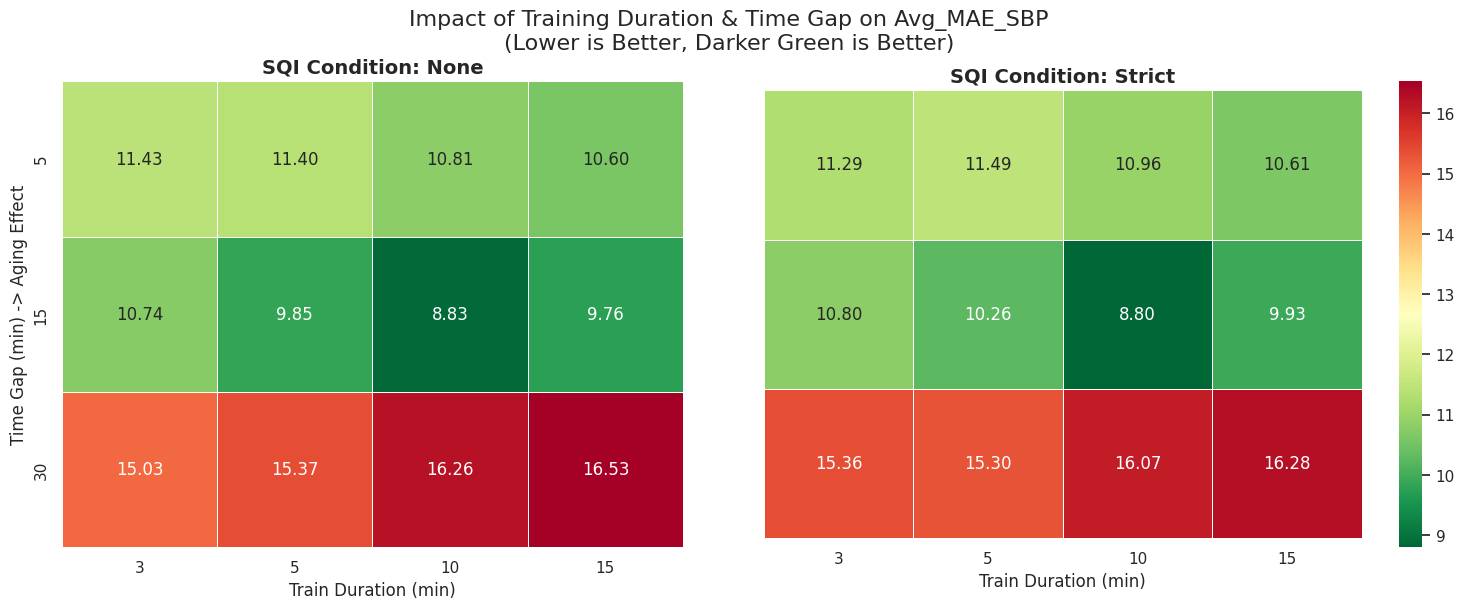

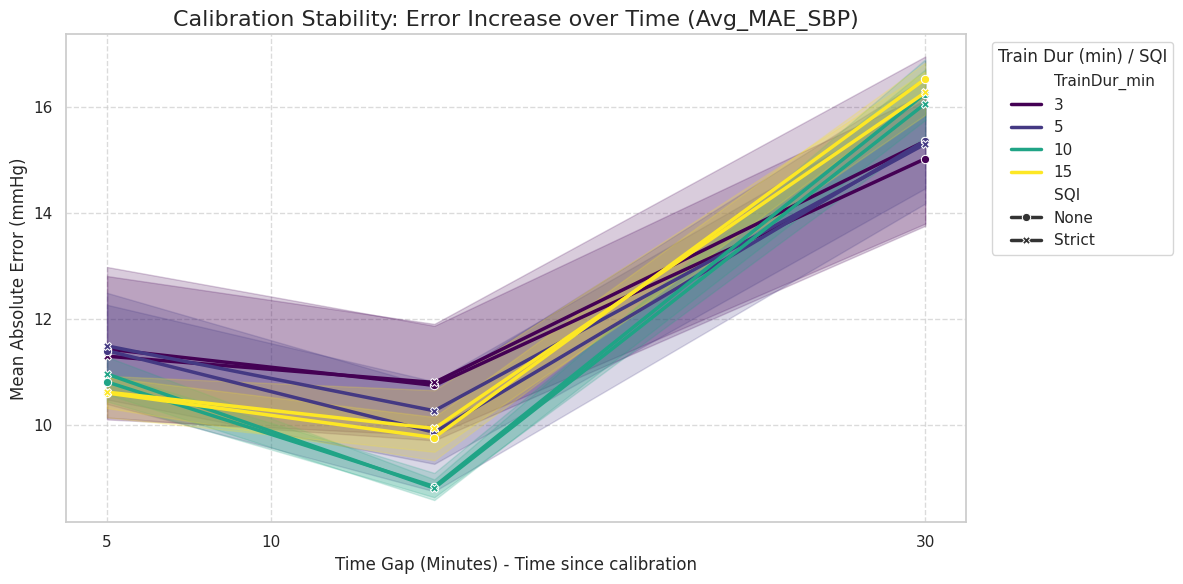

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

file_path = '/content/experiment_sweep_results.csv'
df = pd.read_csv(file_path)

if df['SQI'].isnull().any():
    print("Detected NaNs in SQI column (likely 'None' string parsed as NaN). Restoring...")
    df['SQI'] = df['SQI'].fillna('None')

sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
target_metric = 'Avg_MAE_SBP'

# ============================================================
# [Plot 1] Heatmap: Train Duration vs Time Gap (SQI 별 비교)
# ============================================================
df_avg = df.groupby(['SQI', 'TrainDur_min', 'TimeGap_min'])[target_metric].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig.suptitle(f'Impact of Training Duration & Time Gap on {target_metric}\n(Lower is Better, Darker Green is Better)', fontsize=16)

vmin, vmax = df_avg[target_metric].min(), df_avg[target_metric].max()
sqi_conditions = ['None', 'Strict']

for i, sqi in enumerate(sqi_conditions):
    data = df_avg[df_avg['SQI'] == sqi]
    pivot_table = data.pivot(index="TimeGap_min", columns="TrainDur_min", values=target_metric)

    if not pivot_table.empty:
        sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="RdYlGn_r",
                    ax=axes[i], vmin=vmin, vmax=vmax, cbar=True if i==1 else False,
                    linewidths=.5, square=True)
        axes[i].set_title(f"SQI Condition: {sqi}", fontsize=14, fontweight='bold')
    else:
        axes[i].text(0.5, 0.5, "No Data Available", ha='center', va='center')
        axes[i].set_title(f"SQI Condition: {sqi} (Empty)", fontsize=14)

    axes[i].set_xlabel("Train Duration (min)", fontsize=12)
    if i == 0:
        axes[i].set_ylabel("Time Gap (min) -> Aging Effect", fontsize=12)
    else:
        axes[i].set_ylabel("")

plt.tight_layout()
plt.show()

# ============================================================
# [Plot 2] Line Plot: Calibration Stability
# ============================================================
plt.figure(figsize=(12, 6))

sns.lineplot(
    data=df,
    x="TimeGap_min",
    y=target_metric,
    hue="TrainDur_min",
    style="SQI",
    palette="viridis",
    markers=True,
    dashes=False,
    linewidth=2.5
)

plt.title(f"Calibration Stability: Error Increase over Time ({target_metric})", fontsize=16)
plt.xlabel("Time Gap (Minutes) - Time since calibration", fontsize=12)
plt.ylabel("Mean Absolute Error (mmHg)", fontsize=12)
plt.legend(title="Train Dur (min) / SQI", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([5, 10, 30])

plt.tight_layout()
plt.show()